# Task 3: Advanced CNN and TransferLearning


We train a CNN, based on a larger [dataset](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no) with 3k brain MRI images. Then we further finetune the model based on our original dataset. 

In [1]:
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

import shap

from data import get_img_dataset
from project3Lib.transforms import EnhanceContrast
import project3Lib.CNN as cnn
from project3Lib.CNN import train_model, test, predict
import project3Lib.utils as utils

from masked_dataset import MaskedDataset

/Users/noraschneider/opt/anaconda3/envs/BrainMRI/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Import TransferLearning Dataset
transferlearning_path = "data/tl_dataset"
transform = [EnhanceContrast(reduce_dim=False), transforms.Grayscale()]
tl_train_dataset,tl_val_dataset, tl_test_dataset = get_img_dataset(transform, data_path=transferlearning_path, use_same_transforms = True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 64
tl_trainloader = DataLoader(tl_train_dataset, batch_size=batch_size, shuffle=True)
tl_testloader = DataLoader(tl_test_dataset, batch_size=batch_size, shuffle=False)
tl_validloader = DataLoader(tl_val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train' : tl_trainloader, 
    'validation': tl_validloader
}

image_datasets = {
    'train': tl_train_dataset,
    'validation': tl_val_dataset
}

Loaded samples into dataset with label 'no'=0 and 'yes'=1
Device state: cpu


# Model implementation
## 1. Train model on large dataset

In [3]:
model = cnn.CNN()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 30
model = train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=epochs)

Epoch 1/30
----------
train loss: 0.6877, acc: 0.5150
validation loss: 0.7080, acc: 0.5100
Epoch 2/30
----------
train loss: 0.5864, acc: 0.7312
validation loss: 0.5300, acc: 0.7667
Epoch 3/30
----------



KeyboardInterrupt



In [6]:
torch.save(model.state_dict(), f"trained_weights/TL_basemodel.pt")

**Evaluate base model and SHAP** 

In [4]:
model = cnn.CNN()
model.load_state_dict(torch.load("trained_weights/TL_basemodel.pt"))

<All keys matched successfully>

Mean values 0.4699663539159779, 0.5300336475585471


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Image #0: True Class 1, Prediction 1, Probabilities tensor([[4.1586e-19, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


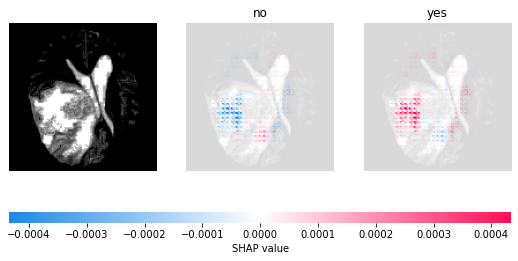

Image #1: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 4.3451e-10]], grad_fn=<SoftmaxBackward0>)


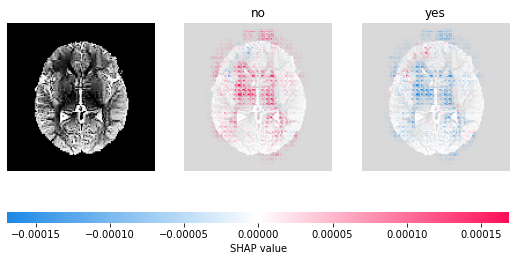

Image #2: True Class 1, Prediction 1, Probabilities tensor([[7.2416e-32, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


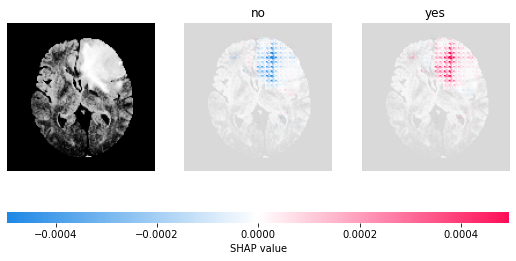

Image #3: True Class 1, Prediction 1, Probabilities tensor([[0., 1.]], grad_fn=<SoftmaxBackward0>)


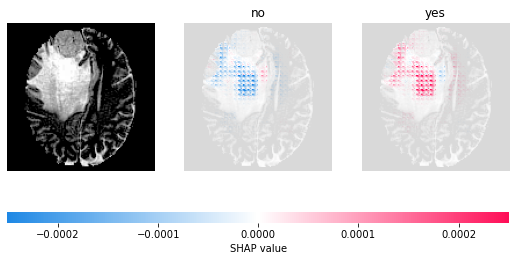

Image #4: True Class 0, Prediction 0, Probabilities tensor([[0.8063, 0.1937]], grad_fn=<SoftmaxBackward0>)


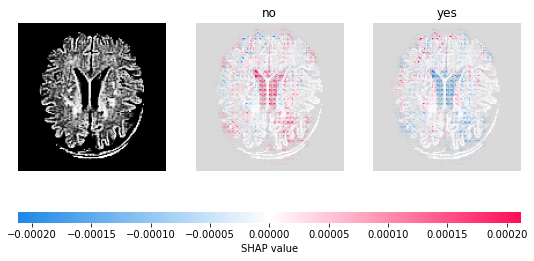

Image #5: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 4.0794e-07]], grad_fn=<SoftmaxBackward0>)


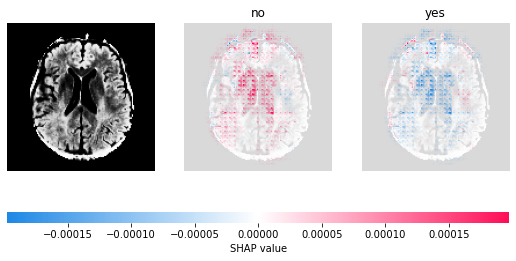

Image #6: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 1.5319e-09]], grad_fn=<SoftmaxBackward0>)


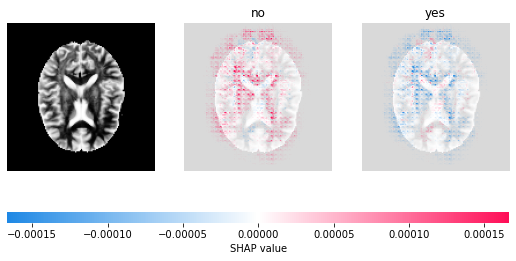

Image #7: True Class 1, Prediction 1, Probabilities tensor([[7.3489e-05, 9.9993e-01]], grad_fn=<SoftmaxBackward0>)


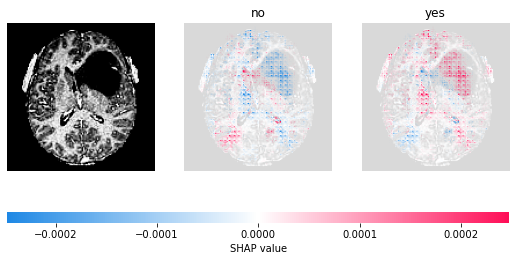

Image #8: True Class 1, Prediction 1, Probabilities tensor([[7.5670e-44, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


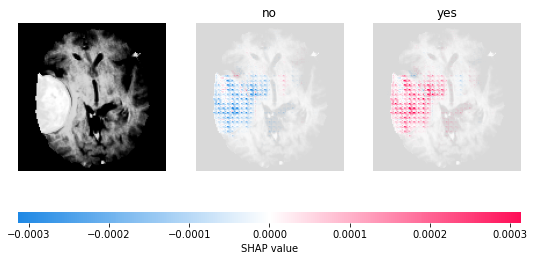

Image #9: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 3.1537e-09]], grad_fn=<SoftmaxBackward0>)


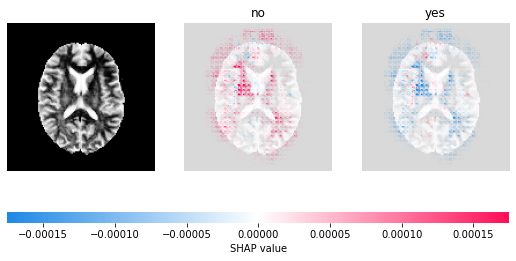

In [9]:
# Deep Explainer
np.random.seed(123)
indices = np.random.randint(0, high=len(tl_train_dataset), size=100)
bg = torch.utils.data.Subset(tl_train_dataset, indices)
bg = [i for i,j in bg]
bg = torch.stack(bg)

e = shap.DeepExplainer(model, bg)

outs = []
for i in bg:
    pred, out = predict(model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")


indices = np.random.randint(0, high=len(tl_test_dataset), size=10)
sub_test = torch.utils.data.Subset(tl_test_dataset, indices)

test_images = [i for i,j in sub_test]
y_test = [j for i,j in sub_test]

for i, image in enumerate(test_images):
    
    image = image.reshape((1,1,128,128))
    pred, out = predict(model,image)
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {y_test[i]}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

## 2. Transfer: finetune model on original dataset

In [8]:
# load and augment original data
unique = input("Use unique images?[yes/no]").lower() == "yes"
input_path = "data/unique_images" if unique else "data/images"

transform = [EnhanceContrast(reduce_dim=False), transforms.Grayscale()]
train_dataset,val_dataset, test_dataset = get_img_dataset(transform, data_path=input_path, use_same_transforms = True)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train' : trainloader, 
    'validation': validloader
}

image_datasets = {
    'train': train_dataset,
    'validation': val_dataset
}

full_retrain = input("Retrain all layers? [yes/no]").lower() == "yes"

Use unique images?[yes/no]yes
Loaded samples into dataset with label 'no'=0 and 'yes'=1
Device state: cpu
Retrain all layers? [yes/no]yes


In [9]:
transfer_model = cnn.CNN()
transfer_model.load_state_dict(torch.load("trained_weights/TL_basemodel.pt"))
if not full_retrain:
    for param in transfer_model.parameters():
        param.requires_grad = False
    for layer in transfer_model.modules():
        if isinstance(layer, nn.Linear):
            layer.weight.requires_grad = True

total_trainable_params = sum(
    p.numel() for p in transfer_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

294,818 training parameters.


In [14]:
criterion = CrossEntropyLoss()
optimizer = Adam(transfer_model.parameters(), lr=0.0005)
epochs = 20
transfer_model = train_model(transfer_model, criterion, optimizer, dataloaders, image_datasets, num_epochs=epochs)

Epoch 1/20
----------
train loss: 0.3487, acc: 0.9620
validation loss: 0.4632, acc: 0.8500
Epoch 2/20
----------
train loss: 0.3386, acc: 0.9747
validation loss: 0.4628, acc: 0.8500
Epoch 3/20
----------
train loss: 0.3397, acc: 0.9747
validation loss: 0.4608, acc: 0.8500
Epoch 4/20
----------
train loss: 0.3403, acc: 0.9747
validation loss: 0.4626, acc: 0.8500
Epoch 5/20
----------
train loss: 0.3340, acc: 0.9810
validation loss: 0.4634, acc: 0.8500
Epoch 6/20
----------
train loss: 0.3324, acc: 0.9810
validation loss: 0.4470, acc: 0.8500
Epoch 7/20
----------
train loss: 0.3333, acc: 0.9810
validation loss: 0.4341, acc: 0.8500
Epoch 8/20
----------
train loss: 0.3388, acc: 0.9684
validation loss: 0.4417, acc: 0.8500
Epoch 9/20
----------
train loss: 0.3380, acc: 0.9747
validation loss: 0.4637, acc: 0.8500
Epoch 10/20
----------
train loss: 0.3429, acc: 0.9684
validation loss: 0.4141, acc: 0.9000
Epoch 11/20
----------
train loss: 0.3361, acc: 0.9747
validation loss: 0.4199, acc: 0.90

In [17]:
torch.save(transfer_model.state_dict(), f"trained_weights/TL_model.pt")

# Evaluate final Classifier

In [10]:
transfer_model = cnn.CNN()
transfer_model.load_state_dict(torch.load("trained_weights/TL_model.pt"))

<All keys matched successfully>

Accuracy: 0.95
F1 score: 0.9565217391304348


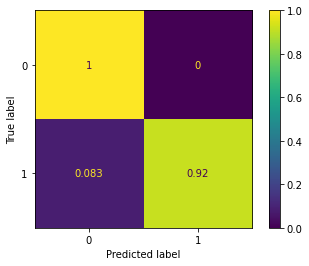

In [11]:
x_test = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]
preds = []
outs = []
for t in x_test:
    pred, out = predict(transfer_model, t)
    preds.append(pred)
    
print(f"Accuracy: {accuracy_score(preds,y_test)}")
print(f"F1 score: {f1_score(preds,y_test)}")

cm=confusion_matrix(y_test,preds,normalize="true")
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

```
Accuracy: 0.95
F1 score: 0.9565217391304348
```

![](Plots/CM_CNN_TL.png)

# Interpretability
## SHAP

In [12]:
transform = [transforms.Grayscale()]
common_transform = [EnhanceContrast(reduce_dim=False)]
_,_, test_dataset = get_img_dataset(transform = transform, \
                                    use_same_transforms=True, \
                                    common_transforms=common_transform, \
                                    data_path=input_path, \
                                    folder_type = MaskedDataset, \
                                    mask_folder=Path("data/masks"))

Loaded samples into dataset with label 'no'=0 and 'yes'=1


In [13]:
# Deep Explainer
bg = [i for i,j in train_dataset]
bg = torch.stack(bg)
e = shap.DeepExplainer(transfer_model, bg)
outs = []
for i in bg:
    pred, out = predict(transfer_model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")

Mean values 0.4556974236207898, 0.5443025763527766


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Image #0: True Class 1, Prediction 1, Probabilities tensor([[9.0289e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


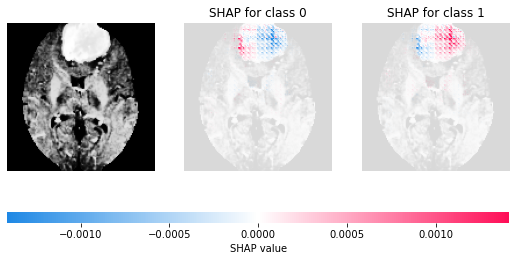

0.39751919669226227
Image #1: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 1.0730e-08]], grad_fn=<SoftmaxBackward0>)


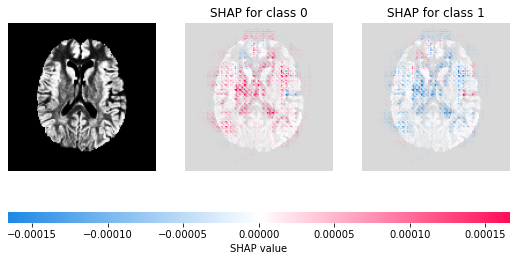

1.0
Image #2: True Class 1, Prediction 0, Probabilities tensor([[1.0000e+00, 7.9801e-10]], grad_fn=<SoftmaxBackward0>)


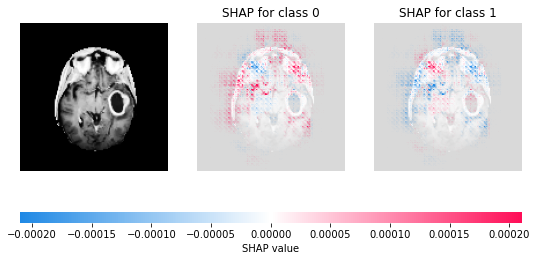

0.03525046382189239
Image #3: True Class 1, Prediction 1, Probabilities tensor([[1.6800e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


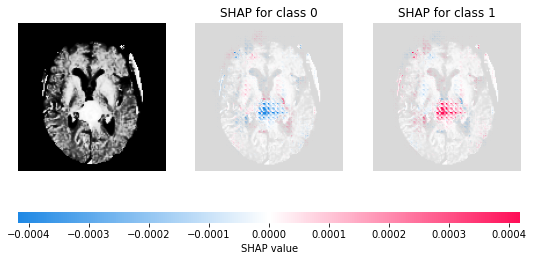

0.36363636363636365
Image #4: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 1.5893e-11]], grad_fn=<SoftmaxBackward0>)


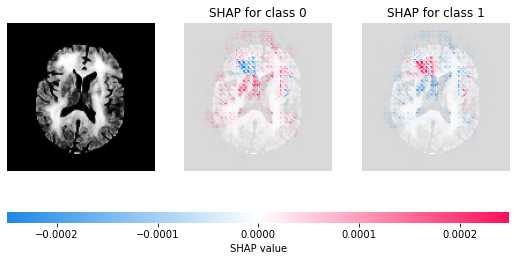

1.0
Image #5: True Class 1, Prediction 1, Probabilities tensor([[1.5588e-19, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


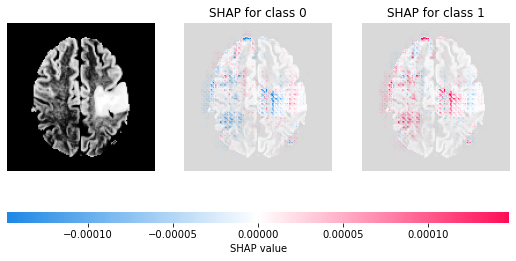

0.09430756159728122
Image #6: True Class 1, Prediction 1, Probabilities tensor([[7.4211e-11, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


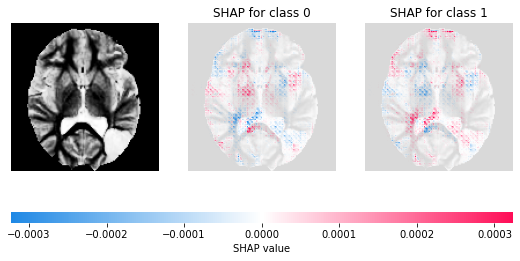

0.03366696997270246
Image #7: True Class 1, Prediction 1, Probabilities tensor([[1.9470e-12, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


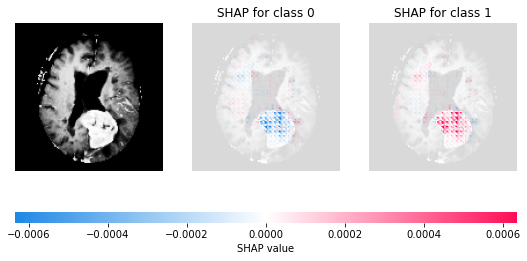

0.4141012909632572
Image #8: True Class 1, Prediction 1, Probabilities tensor([[3.6457e-31, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


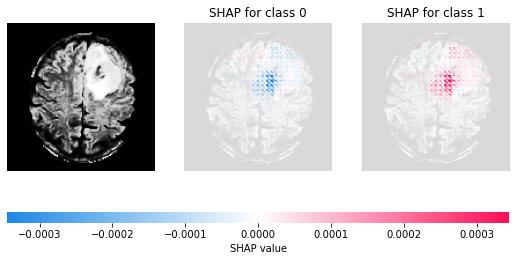

0.3572311495673671
Image #9: True Class 1, Prediction 1, Probabilities tensor([[6.5551e-31, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


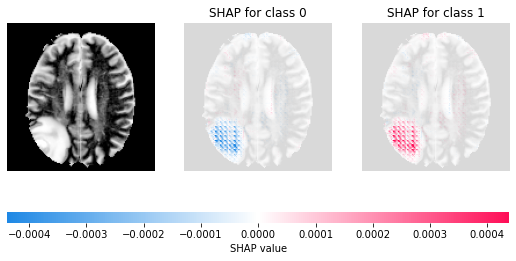

0.4713656387665198
Image #10: True Class 1, Prediction 1, Probabilities tensor([[2.7690e-13, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


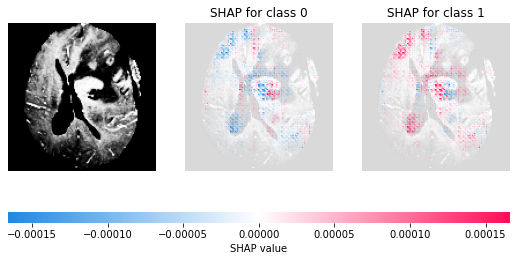

0.15736551030668677
Image #11: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 2.1873e-09]], grad_fn=<SoftmaxBackward0>)


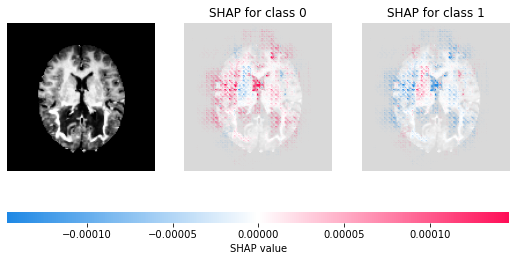

1.0
Image #12: True Class 0, Prediction 0, Probabilities tensor([[9.9986e-01, 1.3743e-04]], grad_fn=<SoftmaxBackward0>)


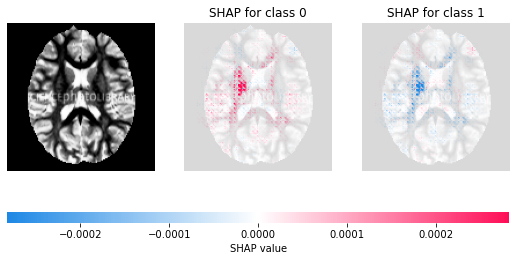

1.0
Image #13: True Class 1, Prediction 1, Probabilities tensor([[3.0542e-04, 9.9969e-01]], grad_fn=<SoftmaxBackward0>)


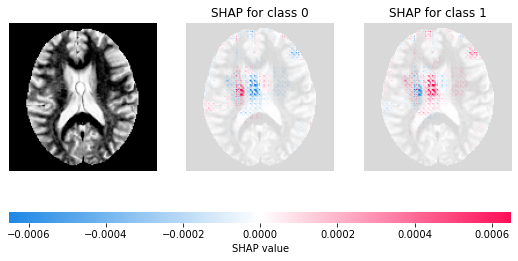

0.0023730422401518746
Image #14: True Class 1, Prediction 1, Probabilities tensor([[4.6135e-17, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


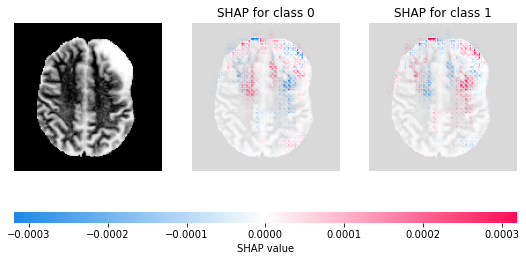

0.13249211356466878
Image #15: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 1.4409e-09]], grad_fn=<SoftmaxBackward0>)


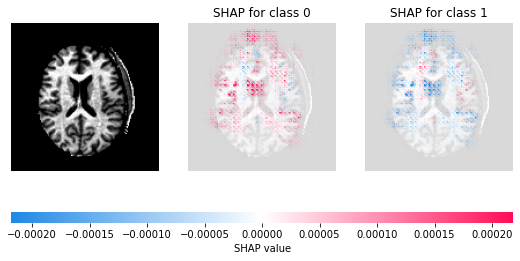

1.0
Image #16: True Class 1, Prediction 1, Probabilities tensor([[2.7549e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


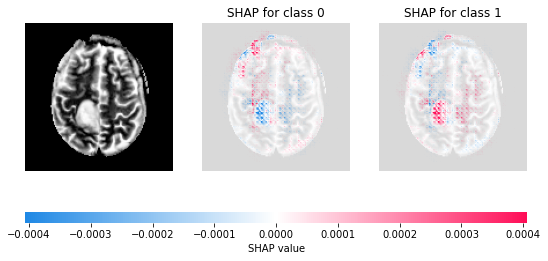

0.2271604938271605
Image #17: True Class 0, Prediction 0, Probabilities tensor([[9.9974e-01, 2.5582e-04]], grad_fn=<SoftmaxBackward0>)


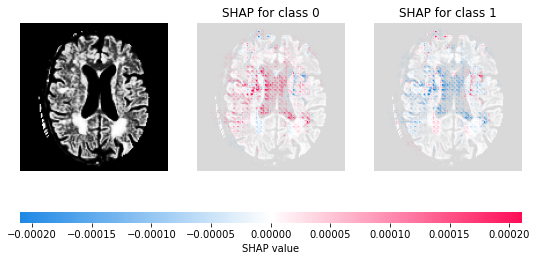

1.0
Image #18: True Class 0, Prediction 0, Probabilities tensor([[9.9999e-01, 1.3963e-05]], grad_fn=<SoftmaxBackward0>)


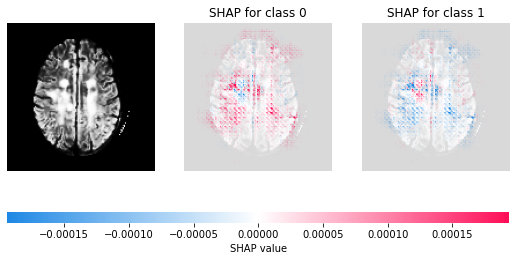

1.0
Image #19: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 4.9065e-08]], grad_fn=<SoftmaxBackward0>)


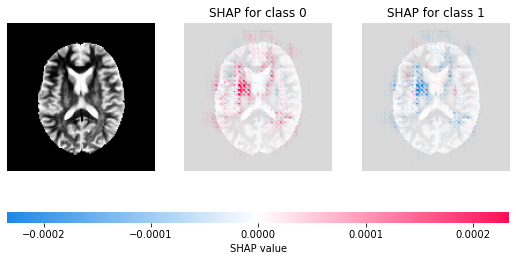

1.0
Mean IOU: 0.22387248291302617


In [14]:
ious = []
for i, (image,mask,target) in enumerate(test_dataset):
    image = image.reshape((1,1,128,128))
    pred, out = predict(model,image)
    
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {target}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["SHAP for class 0","SHAP for class 1"])
    
    predicted_mask = np.copy(shap_values[1].reshape(128,128))
    mask = mask.numpy().reshape((128,128))
    pixels = int(np.sum(mask.flatten()))
    iou = utils.evaluate_interpretability(predicted_mask, mask,pixels)
    print(iou)
    if target == 1:
        ious.append(iou)
print(f"Mean IOU: {np.mean(ious)}")

```
Mean IOU: 0.22387248291302617
```